In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, clear_output
from functools import partial

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

from src.config import Config
from src.episode import Episode
from src.episode_dataset import EpisodeDataset
from src.rl_data_record import RLDataRecord
from src.policy import Policy
from src.reward_model import RewardModel
from src.grpo_trainer import GRPOTrainer
from src.policy_model_utils import load_policy_model, save_policy_model, train_and_plot_policy, inference_and_plot_policy
from src.utils import get_color, normalize_min_max, to_device_collate, top_k_sampling
from src.episode_batch_reat_sampler import EpisodeBatchRepeatSampler

# Setup
---

In [2]:
config = Config()
reward_model = RewardModel(config=config)

# Datasets

train_dataset = EpisodeDataset(config=config, split="TRAIN")
print(f"train_dataset : {len(train_dataset)}")

test_dataset = EpisodeDataset(config=config, split="TEST")
print(f"test_dataset : {len(test_dataset)}")

eval_dataset = EpisodeDataset(config=config, split="EVAL")
print(f"eval_dataset : {len(eval_dataset)}")


# DataLoaders
def get_data_loader(
    dataset: EpisodeDataset, batch_size: int, group_size: int, repeats: int
):
    batch_repeat_sampler = EpisodeBatchRepeatSampler(
        dataset=dataset,
        batch_size=batch_size,
        group_size=group_size,
        repeats=repeats,
    )
    # print(
    #     f"batch_repeat_sampler: {len(batch_repeat_sampler)},  {list(batch_repeat_sampler)}"
    # )
    # print(
    #     f"batch ids: {[e.episode_id for e in dataset.get_episods(batch_episode_indices=list(batch_repeat_sampler))]}"
    # )

    to_device_collate_configurable = partial(to_device_collate, config.device)
    dataloader = DataLoader(
        train_dataset,
        batch_size=batch_size * group_size,
        sampler=batch_repeat_sampler,
        collate_fn=to_device_collate_configurable,
    )
    print(f"data loader: {dataset.split}, {len(dataloader)}")
    return dataloader


train_dataloader = get_data_loader(
    dataset=train_dataset,
    batch_size=config.train_batch_size,
    group_size=config.episode_group_size,
    repeats=config.episode_steps,
)
test_dataloader = get_data_loader(
    dataset=test_dataset,
    batch_size=config.test_batch_size,
    group_size=config.episode_group_size,
    repeats=config.episode_steps,
)

eval_dataloader = get_data_loader(
    dataset=eval_dataset,
    batch_size=config.eval_batch_size,
    group_size=config.episode_group_size,
    repeats=config.episode_steps,
)

train_dataset : 100000
test_dataset : 1000
eval_dataset : 100000
data loader: TRAIN, 150
data loader: TEST, 75
data loader: EVAL, 75


In [3]:
# for idx, batch_data in enumerate(train_dataloader):
#     batch_episode_indices = batch_data.get("episode_idx")
#     print(
#         f"idx: {idx}, batch_items: {len(batch_episode_indices)}, batch ids: {[e.episode_id for e in train_dataset.get_episods(batch_episode_indices=batch_episode_indices)]}"
#     )

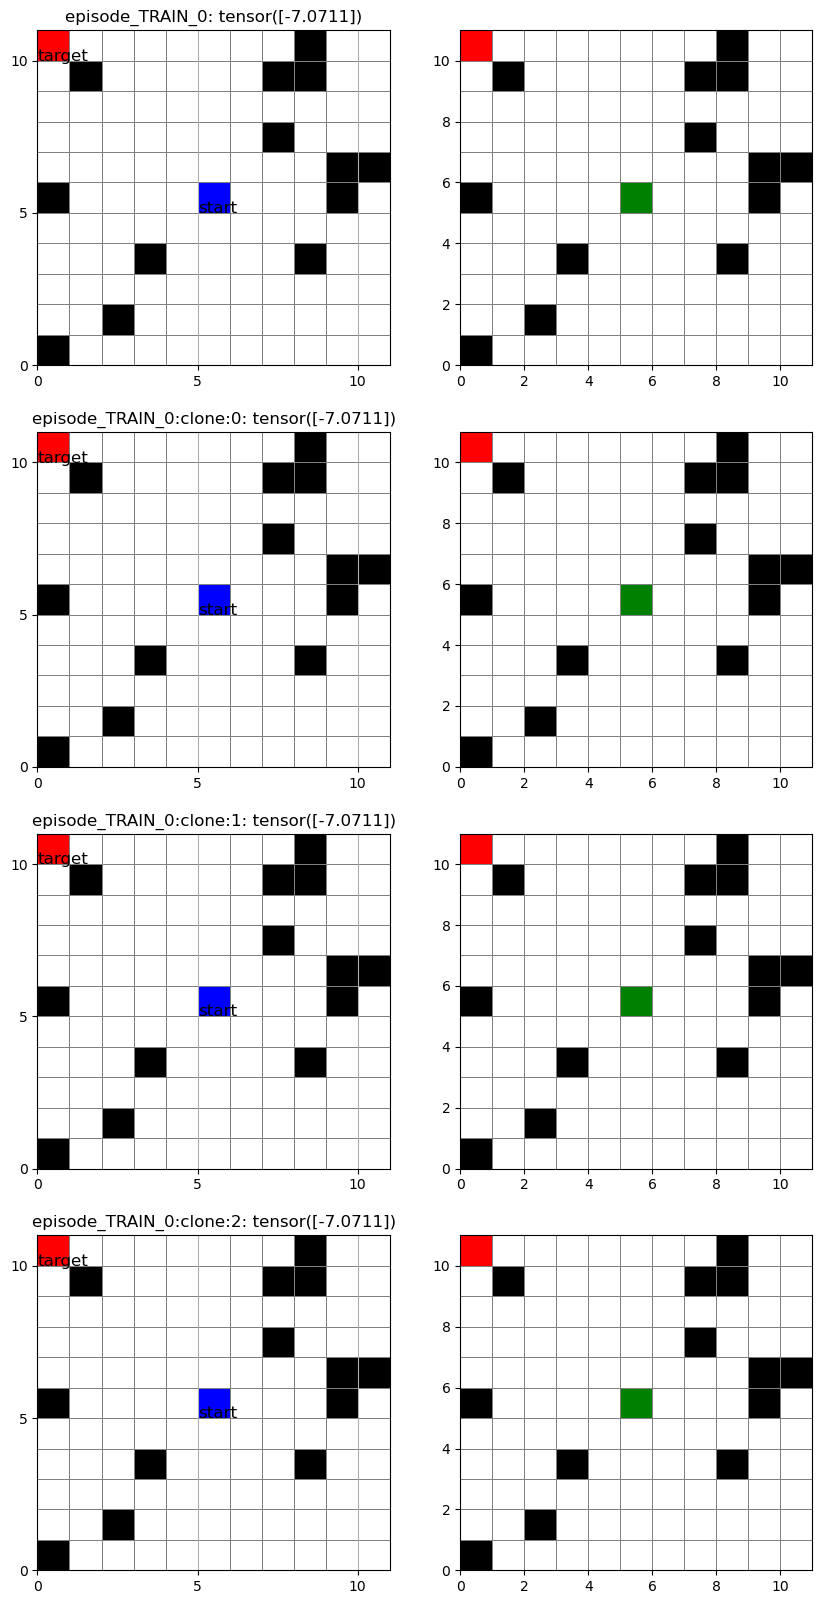

In [4]:
episode_samples = 4
fig, axes = plt.subplots(nrows=episode_samples, ncols=2, figsize=(10, 20))

for eidx in range(episode_samples):
    es = train_dataset.get_episode(eidx)

    es.viz(ax=axes[eidx][0], reward_model=reward_model)

    # Viz fov
    fov = es.fov(center_pos=es.agent.start_state.position())
    # print(f"fov: {fov.size()}, {fov}")
    # print(f"fov: {fov}")
    es.viz_fov(ax=axes[eidx][1])
plt.show()

step: 0, logits: tensor([[-366.2475, -300.0355,  544.0184,  587.7860,   64.5740,   99.5976,
         -431.7953,  189.2742,   94.0761]]), logit_prob: tensor([[0.1771]]), top_k_prob: tensor([[1.]]), action_idx: tensor([[3]]), state: tensor([5, 4]), action_history: [tensor(3)]
step: 1, logits: tensor([[-436.6208, -102.1824,  463.2863,  491.6601,   37.0055,  114.7002,
         -257.8544,  300.4989,  235.5070]]), logit_prob: tensor([[0.1623]]), top_k_prob: tensor([[1.]]), action_idx: tensor([[3]]), state: tensor([5, 3]), action_history: [tensor(3), tensor(3)]
step: 2, logits: tensor([[-285.1011, -170.7974,  411.0071,  435.4332,  231.1863,    4.3916,
         -311.8192,  186.8657,  221.0040]]), logit_prob: tensor([[0.1680]]), top_k_prob: tensor([[1.]]), action_idx: tensor([[3]]), state: tensor([5, 2]), action_history: [tensor(3), tensor(3), tensor(3)]
step: 3, logits: tensor([[-339.4561, -136.8693,  444.4246,  388.3144,  217.3556,   38.8183,
         -246.5225,  258.1139,  212.5595]]), logit

/Users/chengbai/ml/cheng_git/rf_agent/src/policy.py:28: FutureWarning: `nn.init.kaiming_uniform` is now deprecated in favor of `nn.init.kaiming_uniform_`.
  layer.weight = nn.init.kaiming_uniform(layer.weight)


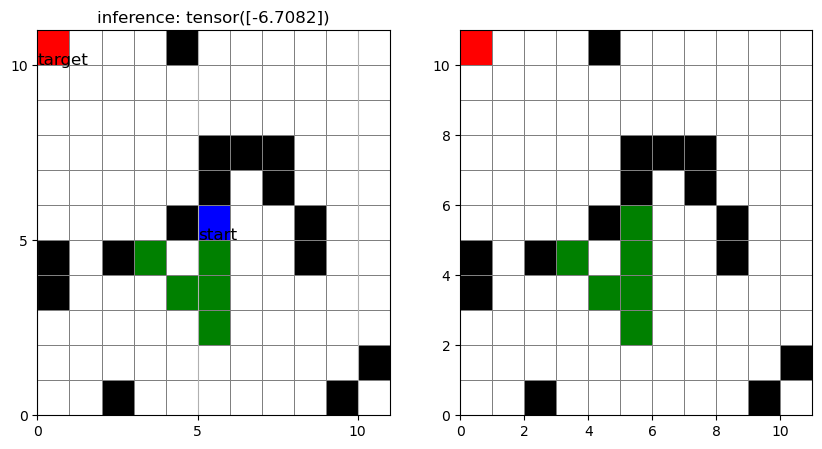

In [5]:
test_policy = Policy(config=config)
episode = inference_and_plot_policy(
    policy=test_policy, config=config, reward_model=reward_model, steps=5, debug=True
)
# episode.agent.action_history

In [6]:
# np.linalg.norm([8, 6], ord=1)
episode.reward(reward_model=reward_model)

tensor([-6.7082])

# Training Loop
---

In [7]:
policy = Policy(config=config)
reward_model = RewardModel(config=config)
trainer = GRPOTrainer(config=config, policy=policy, reward_model=reward_model)

step: 0, logits: tensor([[ -34.0200,  493.6287,  453.6395, -360.8210, -256.8435,  668.1926,
          -57.5499,  158.6743,   58.9683]]), logit_prob: tensor([[0.1788]]), top_k_prob: tensor([[1.]]), action_idx: tensor([[5]]), state: tensor([5, 6]), action_history: [tensor(5)]
step: 1, logits: tensor([[ -35.9539,  405.5327,  349.6540, -208.2791, -215.5059,  571.4335,
          -93.3572,  109.1516,  148.7702]]), logit_prob: tensor([[0.1874]]), top_k_prob: tensor([[1.]]), action_idx: tensor([[5]]), state: tensor([5, 7]), action_history: [tensor(5), tensor(5)]
step: 2, logits: tensor([[ -82.3924,  537.6031,  414.0035, -224.6647, -234.9251,  426.2879,
           26.6010,   27.6010,   14.5943]]), logit_prob: tensor([[0.1836]]), top_k_prob: tensor([[1.]]), action_idx: tensor([[1]]), state: tensor([4, 7]), action_history: [tensor(5), tensor(5), tensor(1)]
step: 3, logits: tensor([[-168.6474,  483.5915,  380.3086, -294.6685, -254.1278,  545.8292,
           78.2301,   87.1778,   17.2455]]), logit

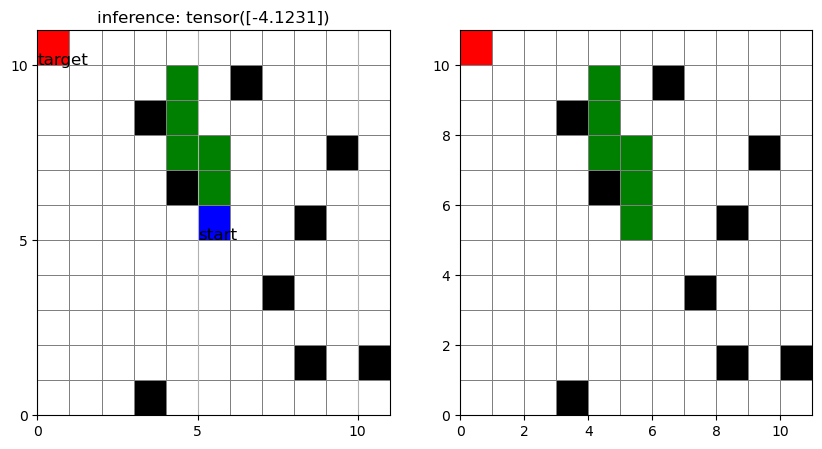

In [8]:
# Before tarin, policy behavior
episode = inference_and_plot_policy(
    policy=policy, config=config, reward_model=reward_model, steps=5, debug=True
)

In [9]:
# plt.ioff()
trainer.run(train_dataset=train_dataset, eval_dataset=eval_dataset, debug=False)
save_policy_model(policy=policy)

# plt.ion()

train_dataloader: 150, eval_dataloader: 75


Epoch 2: 100%|██████████| 75/75 [01:28<00:00,  1.18s/it, split=EVAL, step=10, batch_idx=74, is_episode_step_done=1]

model_path: rf_model_policy_20250525214403.pt
Save policy model to: rf_model_policy_20250525214403.pt


step: 0, logits: tensor([[-2.9176e+11,  3.9073e+11,  6.0876e+11,  3.8013e+10, -7.5046e+10,
          2.8935e+11, -2.0903e+11, -4.2805e+11, -3.5982e+11]]), logit_prob: tensor([[0.1896]]), top_k_prob: tensor([[1.]]), action_idx: tensor([[2]]), state: tensor([4, 6]), action_history: [tensor(2)]
step: 1, logits: tensor([[-2.6402e+11,  3.5357e+11,  5.5087e+11,  3.4399e+10, -6.7911e+10,
          2.6184e+11, -1.8915e+11, -3.8735e+11, -3.2560e+11]]), logit_prob: tensor([[0.1896]]), top_k_prob: tensor([[1.]]), action_idx: tensor([[2]]), state: tensor([3, 7]), action_history: [tensor(2), tensor(2)]
step: 2, logits: tensor([[-2.3484e+11,  3.1449e+11,  4.8997e+11,  3.0607e+10, -6.0389e+10,
          2.3287e+11, -1.6825e+11, -3.4453e+11, -2.8961e+11]]), logit_prob: tensor([[0.1896]]), top_k_prob: tensor([[1.]]), action_idx: tensor([[2]]), state: tensor([2, 8]), action_history: [tensor(2), tensor(2), tensor(2)]
step: 3, logits: tensor([[-2.1162e+11,  2.8340e+11,  4.4153e+11,  2.7577e+10, -5.4423e+1

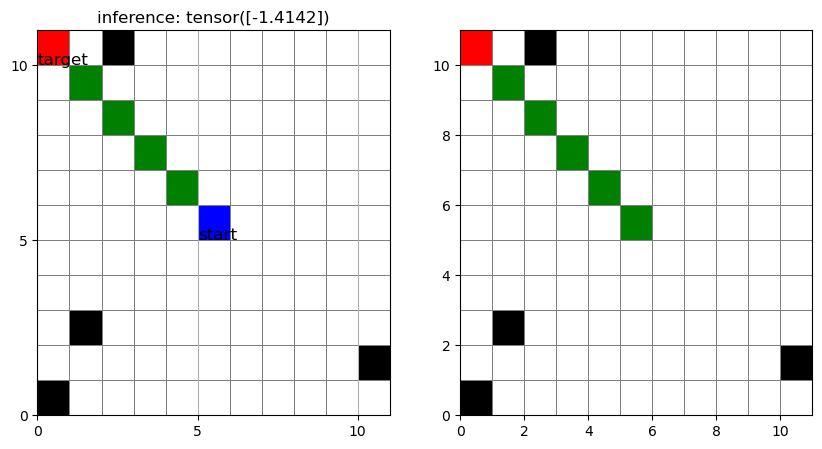

episode reward: tensor([-1.4142])


In [13]:
# post model training
episode = inference_and_plot_policy(
    policy=policy,
    config=config,
    reward_model=reward_model,
    steps=15,  # config.episode_steps,
    debug=True,
)
print(f"episode reward: {episode.reward(reward_model=reward_model)}")

In [11]:
print(f"episode reward: {episode.reward(reward_model=reward_model)}")

episode reward: tensor([-1.4142])


# Evaluate the Model
----

In [12]:
# policy_model_path = (
#     "/Users/chengbai/ml/cheng_git/rf_agent/rf_model_policy_20250510230738_base.pt"
# )
# trained_policy = load_policy_model(config=config, policy_model_path=policy_model_path)
# assert trained_policy is not None

# episode = inference_and_plot_policy(
#     policy=trained_policy, config=config, reward_model=reward_model, steps=5, debug=True
# )